# Experiment to explore the performance of the different B-CVAE models’ behaviour over the architecture found in previous experiments

In [13]:
#Now, we prepare the parameters for the different models in dictionaries and dataclasses
from typing import List, Tuple

import tensorflow as tf
from dataclasses import dataclass, asdict
import numpy as np
from project.infrastructure.images.CVAE import CVAE
from utils.batches.application.batch_selector import BatchSelector
from utils.epsilons.application.epsilon_generator_selector import EpsilonGeneratorSelector
from utils.external.fid.fid import frechet_inception_distance
from utils.losses.images.application.image_loss_function_selector import ImageLossFunctionSelector


@dataclass(frozen=True)
class Dataset:
    dataset: List
    image_height: int
    image_width: int
    n_channels: int


beta_base = {
    "encoder_architecture": [16, 32, 63],
    "decoder_architecture": [60, 48, 32, 16],
    "encoder_sizes":[3, 3, 3],
    "decoder_sizes":[3, 3, 3, 3],
    "encoder_strides":[1, 2, 2],
    "decoder_strides":[1, 2, 1, 1],
    "decoder_input_reshape": (14, 14, 32),
    "encoder_activations": [tf.nn.relu,tf.nn.relu,tf.nn.relu],
    "decoder_activations": [tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu],
    "encoder_output_activation": tf.nn.relu,
    "decoder_input_activation": tf.nn.relu,
    "decoder_output_activation": tf.nn.sigmoid,
    "learning_rate": 0.0001,
    "n_distributions": 5,

}
beta2 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA2_MSE.value,
}
beta5 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA5_MSE.value,
}
beta05 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA05_MSE.value,
}
beta02 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA02_MSE.value,
}

In [21]:
# Common functions

import matplotlib.pyplot as plt


def examples(model, factor = 1.0, cmap = 'gray'):
    generated = model.generate_with_multiple_samples(
        tf.random.normal((9,5)) * factor
    )

    plt.figure()
    fig, axes = plt.subplots(3, 3)
    for i, ax in enumerate(axes.flat):
        image = generated[i]

        ax.imshow(image, cmap=cmap)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def line_plot(y, y_label, x_label, title):
    plt.figure()

    plt.title(title)
    plt.plot(range(1,len(y)+1), y, color='red')

    # Set labels for x and y axes
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()

def perform_analysis(model_name, configuration, dataset, dataset_activations, get_activations_method ,max_iter = 500, times = 10) -> Tuple[CVAE, List, List, List]:
    cvae = CVAE(
        **{**configuration, **asdict(dataset)},
        max_iter=max_iter,
    )

    fids = []
    losses = []
    summaries = []
    for t in range(1, times+1):
        loss, summary = cvae.fit_dataset(
            return_loss=True,
            epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
            batch_size=64,
            batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
            generate_samples=False,
        )

        # we select random images from the dataset
        generated_images = cvae.generate_with_random_sample(dataset_activations.shape[0])
        generated_activations = get_activations_method(generated_images)

        try:
            frechet_inception_distance_metric = frechet_inception_distance(
                dataset_activations,
                generated_activations
            )
        except Exception:
            frechet_inception_distance_metric = np.inf

        fids.append(frechet_inception_distance_metric)
        losses=losses+loss
        summaries=summaries+summary

    print(f"LOSS RESULTS OF {model_name}:\n")
    line_plot(losses, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
    line_plot(list(map(lambda x: x["beta-dkl"],summaries)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
    line_plot(list(map(lambda x: x["mse"],summaries)), 'MSE values', 'Iterations', 'MSE Over Iterations')
    print("")
    print("FIDS:\n")
    line_plot(fids, 'FID', 'Trainings', 'FID Over Trainings')

    return cvae, fids, losses, summaries

def perform_comparison(fids,losses, summaries, models, cmap="gray", mapping=("2-VAE", "5-VAE", "0.5-VAE", "0.2-VAE")):
    tmp_fids = [fid_list[-1] for fid_list in fids]
    tmp_losses = [loss_list[-1] for loss_list in losses]
    tmp_bdkl_summaries = [summary_list[-1]["beta-dkl"] for summary_list in summaries]
    tmp_mse_summaries = [summary_list[-1]["mse"] for summary_list in summaries]

    print("THE MODEL WITH THE LOWEST FID IS:")
    print(f"{mapping[tmp_fids.index(min(tmp_fids))]}==========>{min(tmp_fids)}\n")

    print("THE MODEL WITH THE LOWEST LOSS IS:")
    print(f"{mapping[tmp_losses.index(min(tmp_losses))]}==========>{min(tmp_losses)}\n")

    print("THE MODEL WITH THE LOWEST KULLBACK-LEIBLER LOSS IS:")
    print(f"{mapping[tmp_bdkl_summaries.index(min(tmp_bdkl_summaries))]}==========>{min(tmp_bdkl_summaries)}\n")

    print("THE MODEL WITH THE LOWEST MSE LOSS IS:")
    print(f"{mapping[tmp_mse_summaries.index(min(tmp_mse_summaries))]}==========>{min(tmp_mse_summaries)}\n")

    for i in range(len(models)):
        print(f"{mapping[i]} SAMPLING EXAMPLE")
        examples(models[i], cmap=cmap)
        print(f"{mapping[i]} SAMPLING EXAMPLE: X100")
        examples(models[i], factor=100, cmap=cmap)

## MNIST dataset

Now we will see how the B-CVAE models behave over the MNIST dataset. We will train each model and see how the FID evolves within the training and compare the different models: 2-CVAE, 5-CVAE, 0.5-CVAE and 0.2-CVAE

### Preparations

In [4]:
# We prepare the custom inception model for measuring the FID and the dataset

(TRAIN_IMAGES, TRAIN_LABELS), (TEST_IMAGES, TEST_LABELS) = tf.keras.datasets.mnist.load_data()
mnist = Dataset(
    dataset=TRAIN_IMAGES,
    image_width=28,
    image_height=28,
    n_channels=1,
)

def create_inception_mnist_model():
    tmp_model = tf.keras.Sequential()

    # First Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    tmp_model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    tmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
    tmp_model.add(tf.keras.layers.Dropout(0.5))
    tmp_model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return tmp_model

tf.keras.backend.clear_session()

# Preprocess MNIST dataset
x_train = TRAIN_IMAGES.reshape((-1, 28,28,1))
x_test = TEST_IMAGES.reshape((-1, 28,28,1))
x_train = tf.cast(x_train, dtype=tf.float32) / 255.0
x_test = tf.cast(x_test, dtype=tf.float32) / 255.0
y_train = tf.keras.utils.to_categorical(TRAIN_LABELS, num_classes=10)
y_test = tf.keras.utils.to_categorical(TEST_LABELS, num_classes=10)

model = create_inception_mnist_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

INTERCEPTED_LAYER_INDEX = 5

intercepted_model_mnist = tf.keras.Model(inputs=model.input, outputs=model.layers[INTERCEPTED_LAYER_INDEX].output)

def get_activations_mnist(x : tf.Tensor) -> tf.Tensor:
    return tf.convert_to_tensor(intercepted_model_mnist.predict(x))

Epoch 1/10
1875/1875 [==============================] - 19s 9ms/step - loss: 0.3339 - accuracy: 0.8967 - val_loss: 0.0673 - val_accuracy: 0.9789
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1361 - accuracy: 0.9595 - val_loss: 0.0536 - val_accuracy: 0.9837
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1074 - accuracy: 0.9682 - val_loss: 0.0380 - val_accuracy: 0.9874
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0865 - accuracy: 0.9736 - val_loss: 0.0332 - val_accuracy: 0.9884
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0773 - accuracy: 0.9761 - val_loss: 0.0275 - val_accuracy: 0.9908
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0677 - accuracy: 0.9788 - val_loss: 0.0288 - val_accuracy: 0.9905
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0604 - accuracy: 0.9819 - val_loss: 0.0335 - val_ac

In [6]:
# We prepare the activations of the dataset

mnist_activations = get_activations_mnist(x_test)

313/313 [==============================] - 1s 3ms/step


### Models

#### 2-CVAE

313/313 [==============================] - 1s 5ms/step
LOSS RESULTS OF 2-CVAE:



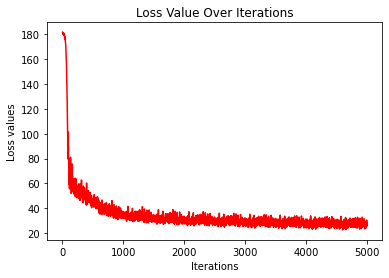

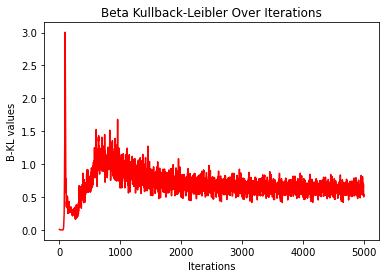

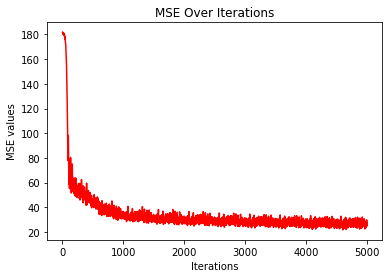


FIDS:



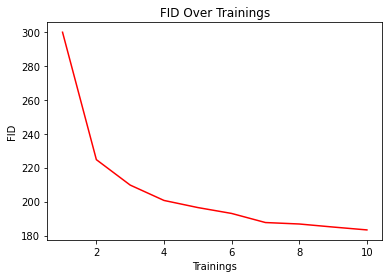

In [22]:
_2CVAE_mnist, fids_2cvae_mnist, losses_2cvae_mnist, summaries_2cvae_mnist =(
    perform_analysis(
        "2-CVAE",
        beta2,
        mnist,
        mnist_activations,
        get_activations_mnist
    )
)

#### 5-CVAE

313/313 [==============================] - 1s 4ms/step
LOSS RESULTS OF 5-CVAE:



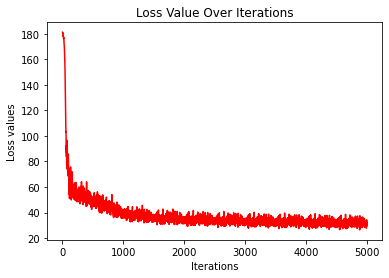

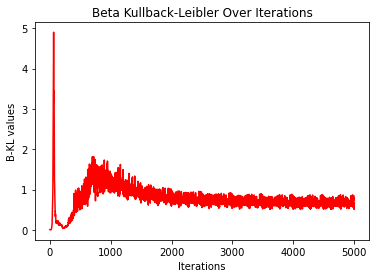

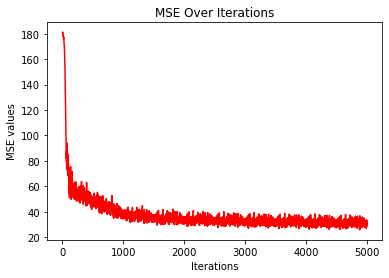


FIDS:



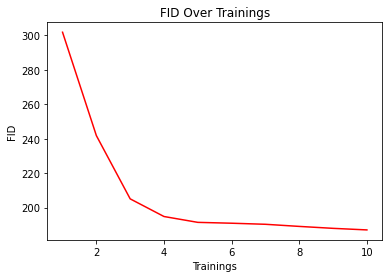

In [23]:
_5CVAE_mnist, fids_5cvae_mnist, losses_5cvae_mnist, summaries_5cvae_mnist =(
    perform_analysis(
        "5-CVAE",
        beta5,
        mnist,
        mnist_activations,
        get_activations_mnist
    )
)

#### 0.5-CVAE

313/313 [==============================] - 2s 5ms/step
LOSS RESULTS OF 0.5-CVAE:



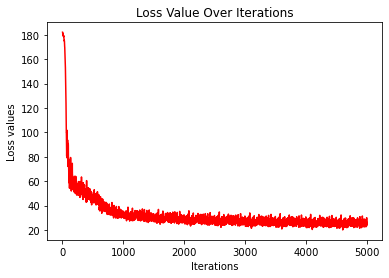

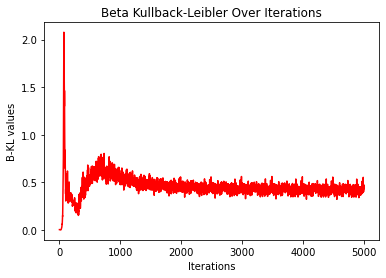

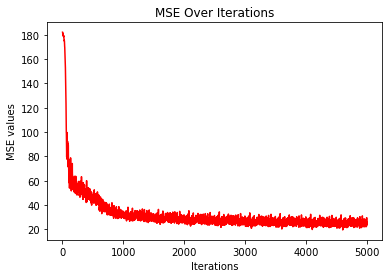


FIDS:



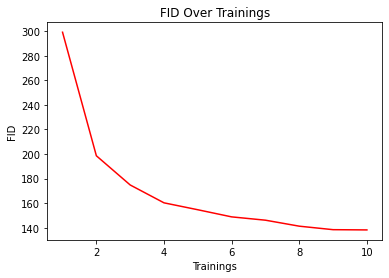

In [24]:
_05CVAE_mnist, fids_05cvae_mnist, losses_05cvae_mnist, summaries_05cvae_mnist =(
    perform_analysis(
        "0.5-CVAE",
        beta05,
        mnist,
        mnist_activations,
        get_activations_mnist
    )
)

#### 0.2-CVAE

313/313 [==============================] - 2s 5ms/step
LOSS RESULTS OF 0.2-CVAE:



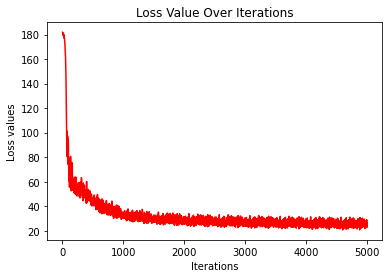

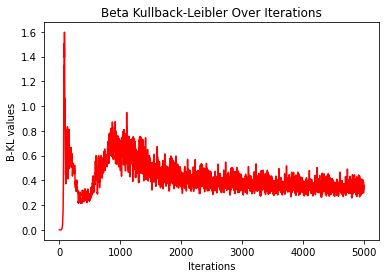

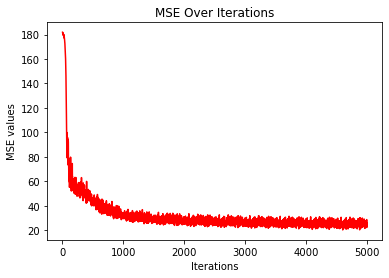


FIDS:



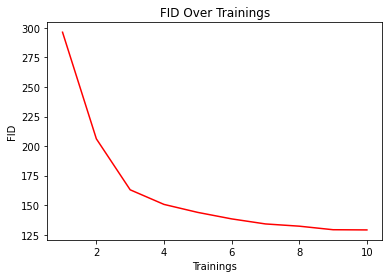

In [25]:
_02CVAE_mnist, fids_02cvae_mnist, losses_02cvae_mnist, summaries_02cvae_mnist =(
    perform_analysis(
        "0.2-CVAE",
        beta02,
        mnist,
        mnist_activations,
        get_activations_mnist
    )
)

#### Comparison

THE MODEL WITH THE LOWEST FID IS:
0.2-VAE==========>129.11413179611668

THE MODEL WITH THE LOWEST LOSS IS:
0.2-VAE==========>25.93411636352539

THE MODEL WITH THE LOWEST KULLBACK-LEIBLER LOSS IS:
0.2-VAE==========>0.3016626238822937

THE MODEL WITH THE LOWEST MSE LOSS IS:
0.2-VAE==========>25.63245391845703

2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

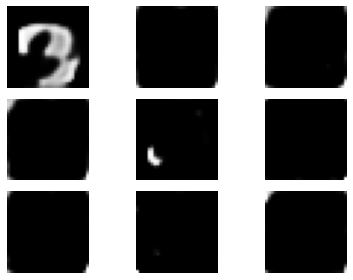

2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

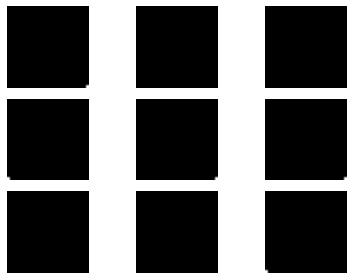

5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

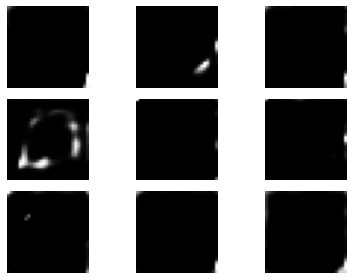

5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

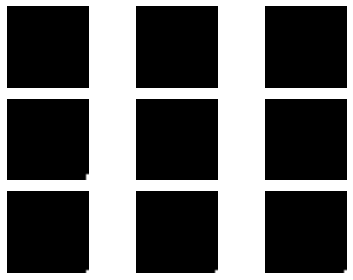

0.5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

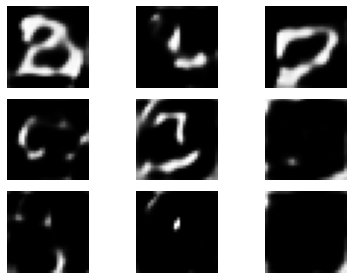

0.5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

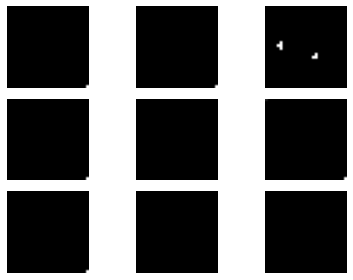

0.2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

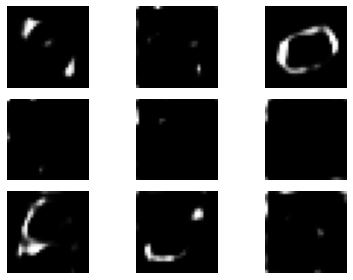

0.2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

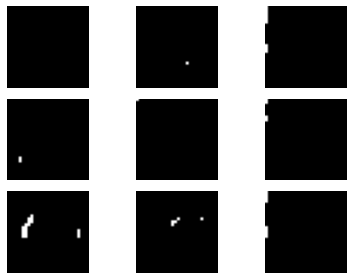

In [26]:
perform_comparison(
    [fids_2cvae_mnist,fids_5cvae_mnist,fids_05cvae_mnist,fids_02cvae_mnist],
    [losses_2cvae_mnist,losses_5cvae_mnist,losses_05cvae_mnist,losses_02cvae_mnist],
    [summaries_2cvae_mnist,summaries_5cvae_mnist,summaries_05cvae_mnist,summaries_02cvae_mnist],
    [_2CVAE_mnist, _5CVAE_mnist, _05CVAE_mnist, _02CVAE_mnist]
)

## FASHION-MNIST dataset

Now we will see how the B-CVAE models behave over the MNIST dataset. We will train each model and see how the FID evolves within the training and compare the different models: 2-CVAE, 5-CVAE, 0.5-CVAE and 0.2-CVAE

### Preparations

In [27]:
# We prepare the custom inception model for measuring the FID and the dataset

(TRAIN_IMAGES, TRAIN_LABELS), (TEST_IMAGES, TEST_LABELS) = tf.keras.datasets.fashion_mnist.load_data()
fashionmnist = Dataset(
    dataset=TRAIN_IMAGES,
    image_width=28,
    image_height=28,
    n_channels=1,
)

def create_inception_fashionmnist_model():
    tmp_model = tf.keras.Sequential()

    # First Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    tmp_model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    tmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
    tmp_model.add(tf.keras.layers.Dropout(0.5))
    tmp_model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return tmp_model

tf.keras.backend.clear_session()

# Preprocess dataset
x_train = TRAIN_IMAGES.reshape((-1, 28,28,1))
x_test = TEST_IMAGES.reshape((-1, 28,28,1))
x_train = tf.cast(x_train, dtype=tf.float32) / 255.0
x_test = tf.cast(x_test, dtype=tf.float32) / 255.0
y_train = tf.keras.utils.to_categorical(TRAIN_LABELS, num_classes=10)
y_test = tf.keras.utils.to_categorical(TEST_LABELS, num_classes=10)

model = create_inception_fashionmnist_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

INTERCEPTED_LAYER_INDEX = 5

intercepted_model_fashionmnist = tf.keras.Model(inputs=model.input, outputs=model.layers[INTERCEPTED_LAYER_INDEX].output)

def get_activations_fashionmnist(x : tf.Tensor) -> tf.Tensor:
    return tf.convert_to_tensor(intercepted_model_fashionmnist.predict(x))

Epoch 1/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.6908 - accuracy: 0.7504 - val_loss: 0.4501 - val_accuracy: 0.8390
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.4930 - accuracy: 0.8213 - val_loss: 0.3884 - val_accuracy: 0.8594
Epoch 3/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.4379 - accuracy: 0.8412 - val_loss: 0.3629 - val_accuracy: 0.8667
Epoch 4/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.4046 - accuracy: 0.8523 - val_loss: 0.3347 - val_accuracy: 0.8782
Epoch 5/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3757 - accuracy: 0.8651 - val_loss: 0.3224 - val_accuracy: 0.8812
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3540 - accuracy: 0.8719 - val_loss: 0.3029 - val_accuracy: 0.8893
Epoch 7/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3362 - accuracy: 0.8792 - val_loss: 0.2961 -

In [28]:
# We prepare the activations of the dataset

fashionmnist_activations = get_activations_mnist(x_test)

313/313 [==============================] - 2s 5ms/step


### Models

#### 2-CVAE

313/313 [==============================] - 1s 4ms/step
LOSS RESULTS OF 2-CVAE:



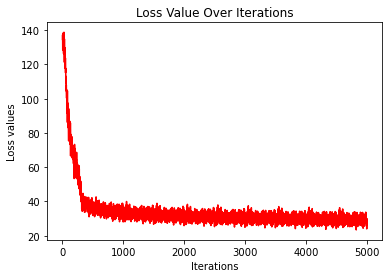

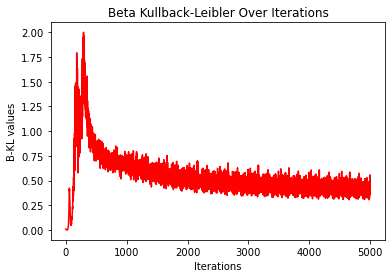

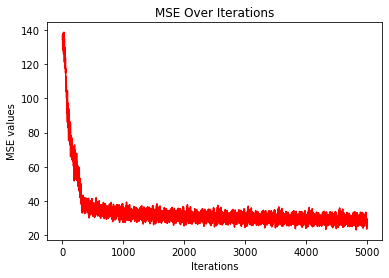


FIDS:



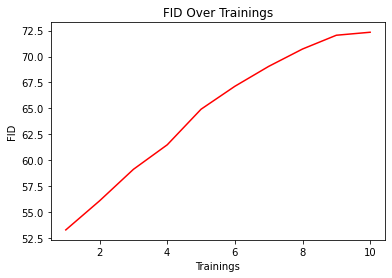

In [29]:
_2CVAE_fashionmnist, fids_2cvae_fashionmnist, losses_2cvae_fashionmnist, summaries_2cvae_fashionmnist =(
    perform_analysis(
        "2-CVAE",
        beta2,
        fashionmnist,
        fashionmnist_activations,
        get_activations_fashionmnist
    )
)

#### 5-CVAE

313/313 [==============================] - 2s 5ms/step
LOSS RESULTS OF 5-CVAE:



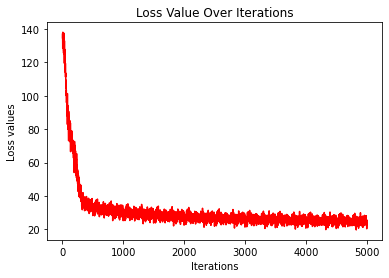

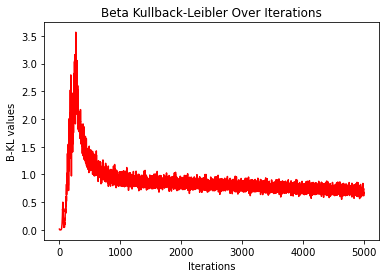

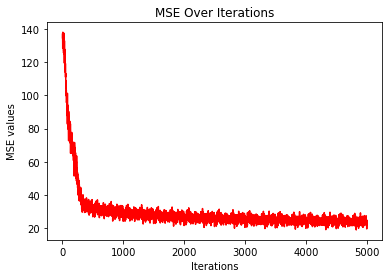


FIDS:



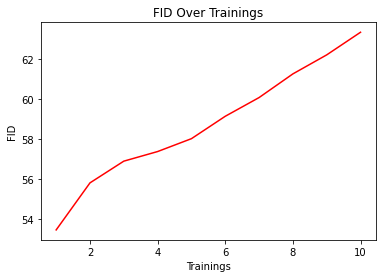

In [30]:
_5CVAE_fashionmnist, fids_5cvae_fashionmnist, losses_5cvae_fashionmnist, summaries_5cvae_fashionmnist =(
    perform_analysis(
        "5-CVAE",
        beta5,
        fashionmnist,
        fashionmnist_activations,
        get_activations_fashionmnist
    )
)

#### 0.5-CVAE

313/313 [==============================] - 2s 6ms/step
LOSS RESULTS OF 0.5-CVAE:



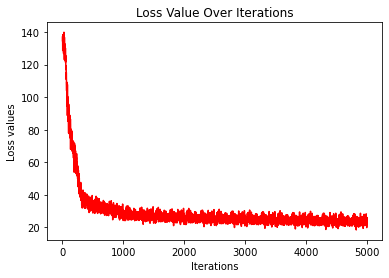

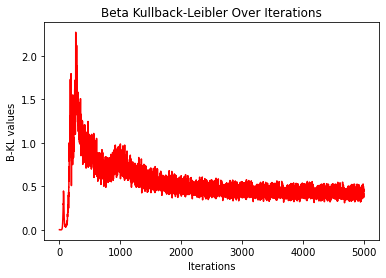

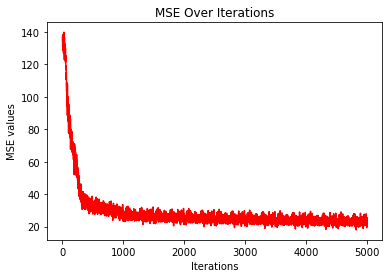


FIDS:



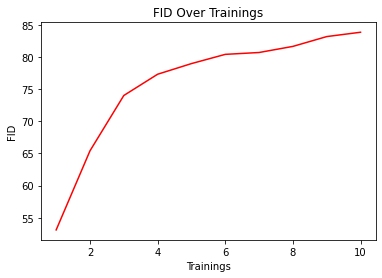

In [31]:
_05CVAE_fashionmnist, fids_05cvae_fashionmnist, losses_05cvae_fashionmnist, summaries_05cvae_fashionmnist =(
    perform_analysis(
        "0.5-CVAE",
        beta05,
        fashionmnist,
        fashionmnist_activations,
        get_activations_fashionmnist
    )
)

#### 0.2-CVAE

313/313 [==============================] - 2s 6ms/step
LOSS RESULTS OF 0.2-CVAE:



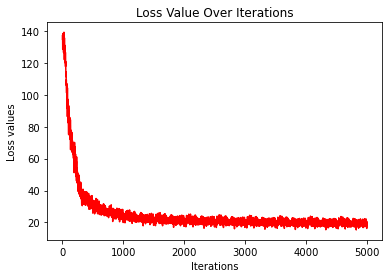

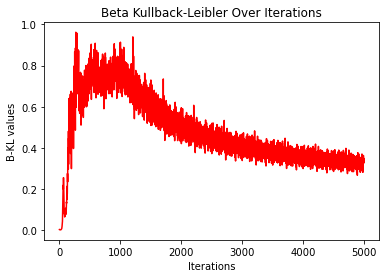

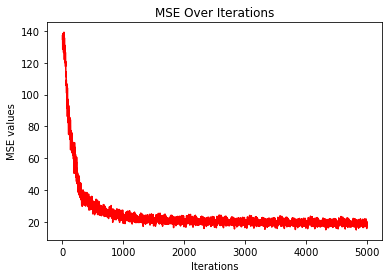


FIDS:



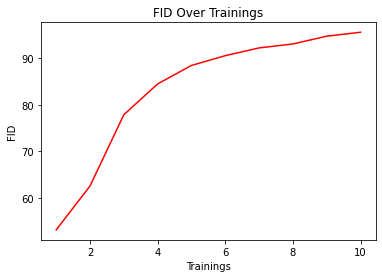

In [32]:
_02CVAE_fashionmnist, fids_02cvae_fashionmnist, losses_02cvae_fashionmnist, summaries_02cvae_fashionmnist =(
    perform_analysis(
        "0.2-CVAE",
        beta02,
        fashionmnist,
        fashionmnist_activations,
        get_activations_fashionmnist
    )
)

#### Comparison

THE MODEL WITH THE LOWEST FID IS:
5-VAE==========>63.356801417367876

THE MODEL WITH THE LOWEST LOSS IS:
0.2-VAE==========>18.82305908203125

THE MODEL WITH THE LOWEST KULLBACK-LEIBLER LOSS IS:
0.2-VAE==========>0.3311797082424164

THE MODEL WITH THE LOWEST MSE LOSS IS:
0.2-VAE==========>18.491878509521484

2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

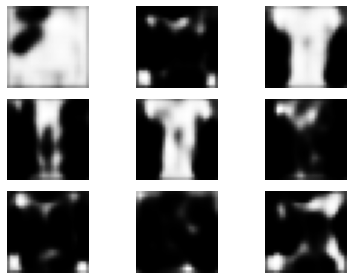

2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

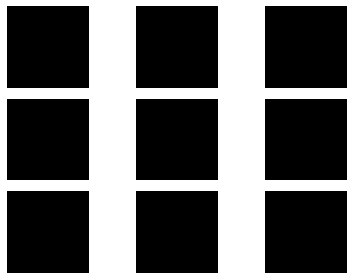

5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

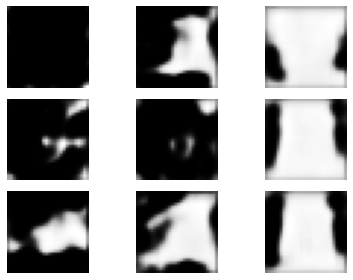

5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

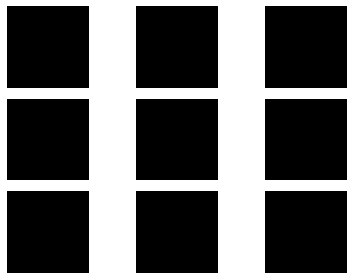

0.5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

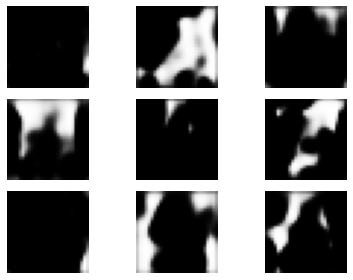

0.5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

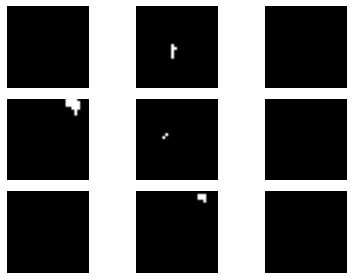

0.2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

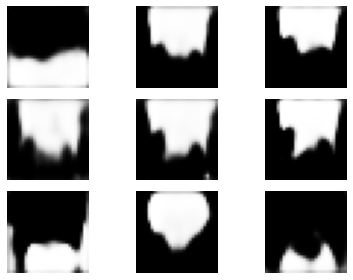

0.2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

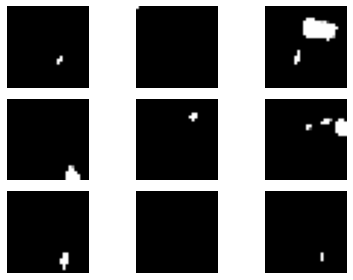

In [33]:
perform_comparison(
    [fids_2cvae_fashionmnist,fids_5cvae_fashionmnist,fids_05cvae_fashionmnist,fids_02cvae_fashionmnist],
    [losses_2cvae_fashionmnist,losses_5cvae_fashionmnist,losses_05cvae_fashionmnist,losses_02cvae_fashionmnist],
    [summaries_2cvae_fashionmnist,summaries_5cvae_fashionmnist,summaries_05cvae_fashionmnist,summaries_02cvae_fashionmnist],
    [_2CVAE_fashionmnist, _5CVAE_fashionmnist, _05CVAE_fashionmnist, _02CVAE_fashionmnist]
)

## CIFAR-10 dataset

Now we will see how the B-CVAE models behave over the CIFAR-10 dataset. We will train each model and see how the FID evolves within the training and compare the different models: 2-CVAE, 5-CVAE, 0.5-CVAE and 0.2-CVAE

### Preparations

In [34]:
# We prepare the custom inception model for measuring the FID and the dataset

(TRAIN_IMAGES, TRAIN_LABELS), (TEST_IMAGES, TEST_LABELS) = tf.keras.datasets.cifar10.load_data()
cifar10 = Dataset(
    dataset=TRAIN_IMAGES,
    image_width=32,
    image_height=32,
    n_channels=3,
)

def create_inception_cifar10_model():
    tmp_model = tf.keras.Sequential()

    # First Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    tmp_model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    tmp_model.add(tf.keras.layers.Dense(256, activation='relu'))
    tmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
    tmp_model.add(tf.keras.layers.Dropout(0.5))
    tmp_model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return tmp_model

tf.keras.backend.clear_session()

# Preprocess dataset
x_train = TRAIN_IMAGES.reshape((-1, 32,32,3))
x_test = TEST_IMAGES.reshape((-1, 32,32,3))
x_train = tf.cast(x_train, dtype=tf.float32) / 255.0
x_test = tf.cast(x_test, dtype=tf.float32) / 255.0
y_train = tf.keras.utils.to_categorical(TRAIN_LABELS, num_classes=10)
y_test = tf.keras.utils.to_categorical(TEST_LABELS, num_classes=10)

model = create_inception_cifar10_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

INTERCEPTED_LAYER_INDEX = 8

intercepted_model_cifar10 = tf.keras.Model(inputs=model.input, outputs=model.layers[INTERCEPTED_LAYER_INDEX].output)

def get_activations_cifar10(x : tf.Tensor) -> tf.Tensor:
    return tf.convert_to_tensor(intercepted_model_cifar10.predict(x))

Epoch 1/10
1563/1563 [==============================] - 115s 71ms/step - loss: 1.6743 - accuracy: 0.3818 - val_loss: 1.2981 - val_accuracy: 0.5308
Epoch 2/10
1563/1563 [==============================] - 110s 70ms/step - loss: 1.2345 - accuracy: 0.5683 - val_loss: 1.1487 - val_accuracy: 0.6040
Epoch 3/10
1563/1563 [==============================] - 111s 71ms/step - loss: 1.0361 - accuracy: 0.6459 - val_loss: 0.9688 - val_accuracy: 0.6632
Epoch 4/10
1563/1563 [==============================] - 111s 71ms/step - loss: 0.9000 - accuracy: 0.6958 - val_loss: 0.9238 - val_accuracy: 0.6888
Epoch 5/10
1563/1563 [==============================] - 111s 71ms/step - loss: 0.8088 - accuracy: 0.7270 - val_loss: 0.8867 - val_accuracy: 0.6997
Epoch 6/10
1563/1563 [==============================] - 111s 71ms/step - loss: 0.7262 - accuracy: 0.7560 - val_loss: 0.8074 - val_accuracy: 0.7210
Epoch 7/10
1563/1563 [==============================] - 112s 71ms/step - loss: 0.6646 - accuracy: 0.7738 - val_loss: 0

In [35]:
# We prepare the activations of the dataset
cifar10_activations = get_activations_cifar10(x_test)

313/313 [==============================] - 6s 20ms/step


### Models

We need to adapt the architecture to make it fit the new dimensions

In [39]:
beta_base = {
    "encoder_architecture": [16, 32, 48, 63],
    "decoder_architecture": [63, 48, 32, 16],
    "encoder_sizes":[3, 3, 3, 3],
    "decoder_sizes":[3, 3, 3, 3],
    "encoder_strides":[1, 2, 2, 1],
    "decoder_strides":[2, 2, 2, 1],
    "decoder_input_reshape": (4, 4, 32),
    "encoder_activations": [tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu],
    "decoder_activations": [tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu],
    "encoder_output_activation": tf.nn.relu,
    "decoder_input_activation": tf.nn.relu,
    "decoder_output_activation": tf.nn.sigmoid,
    "learning_rate": 0.0001,
    "n_distributions": 5,

}
beta2 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA2_MSE.value,
}
beta5 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA5_MSE.value,
}
beta05 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA05_MSE.value,
}
beta02 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA02_MSE.value,
}

#### 2-CVAE

313/313 [==============================] - 5s 17ms/step
LOSS RESULTS OF 2-CVAE:



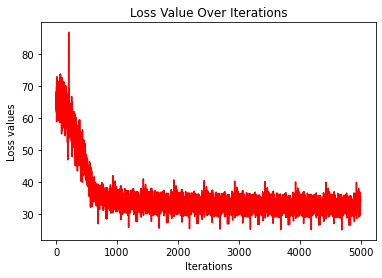

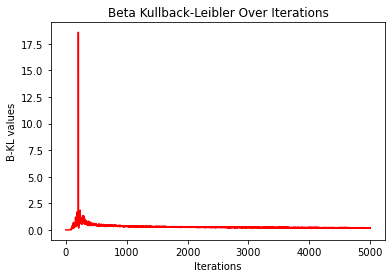

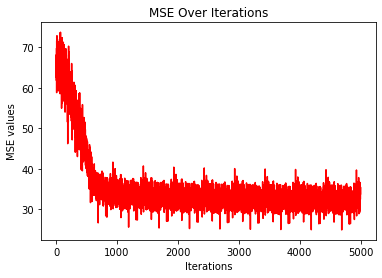


FIDS:



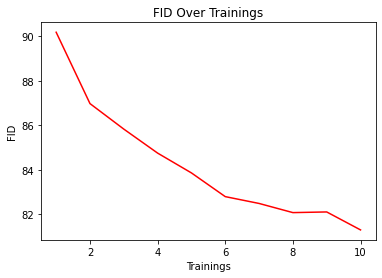

In [40]:
_2CVAE_cifar10, fids_2cvae_cifar10, losses_2cvae_cifar10, summaries_2cvae_cifar10 =(
    perform_analysis(
        "2-CVAE",
        beta2,
        cifar10,
        cifar10_activations,
        get_activations_cifar10
    )
)

#### 5-CVAE

313/313 [==============================] - 5s 17ms/step
LOSS RESULTS OF 5-CVAE:



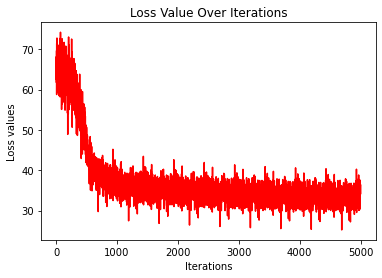

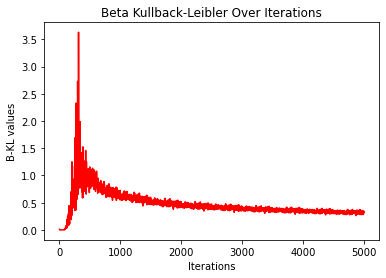

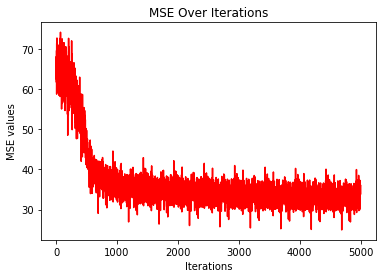


FIDS:



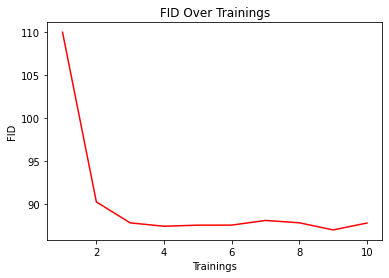

In [41]:
_5CVAE_cifar10, fids_5cvae_cifar10, losses_5cvae_cifar10, summaries_5cvae_cifar10 =(
    perform_analysis(
        "5-CVAE",
        beta5,
        cifar10,
        cifar10_activations,
        get_activations_cifar10
    )
)

#### 0.5-CVAE

313/313 [==============================] - 6s 18ms/step
LOSS RESULTS OF 0.5-CVAE:



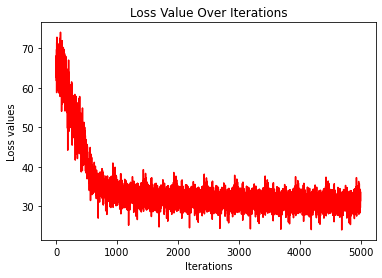

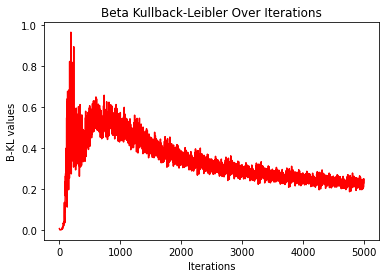

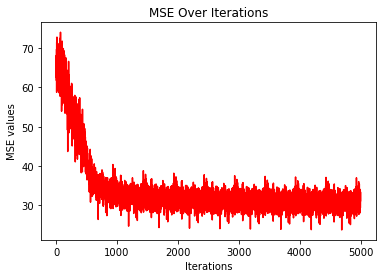


FIDS:



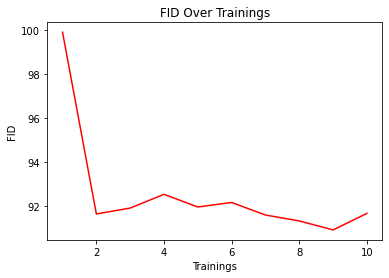

In [42]:
_05CVAE_cifar10, fids_05cvae_cifar10, losses_05cvae_cifar10, summaries_05cvae_cifar10 =(
    perform_analysis(
        "0.5-CVAE",
        beta05,
        cifar10,
        cifar10_activations,
        get_activations_cifar10
    )
)

#### 0.2-CVAE

313/313 [==============================] - 6s 19ms/step
LOSS RESULTS OF 0.2-CVAE:



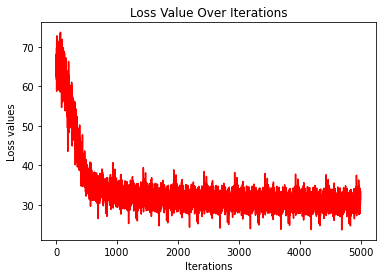

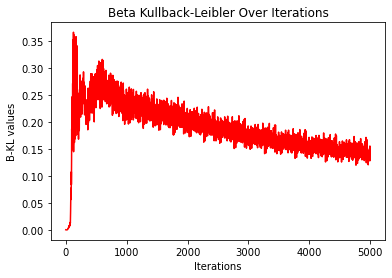

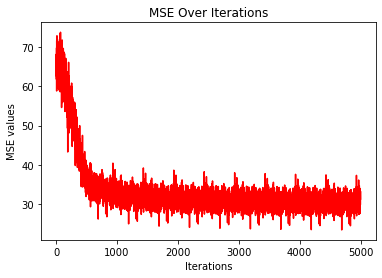


FIDS:



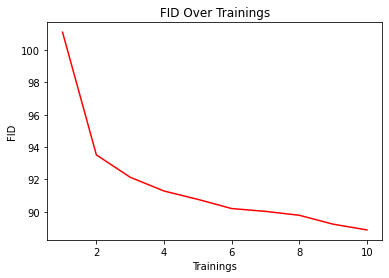

In [43]:
_02CVAE_cifar10, fids_02cvae_cifar10, losses_02cvae_cifar10, summaries_02cvae_cifar10 =(
    perform_analysis(
        "0.2-CVAE",
        beta02,
        cifar10,
        cifar10_activations,
        get_activations_cifar10
    )
)

#### Comparison

THE MODEL WITH THE LOWEST FID IS:
2-VAE==========>81.30338839400949

THE MODEL WITH THE LOWEST LOSS IS:
0.5-VAE==========>31.44777488708496

THE MODEL WITH THE LOWEST KULLBACK-LEIBLER LOSS IS:
0.2-VAE==========>0.14406022429466248

THE MODEL WITH THE LOWEST MSE LOSS IS:
0.5-VAE==========>31.21721839904785

2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

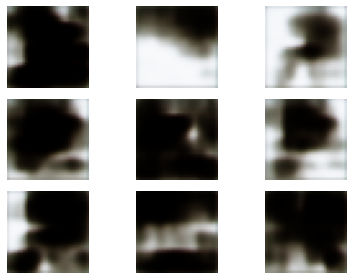

2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

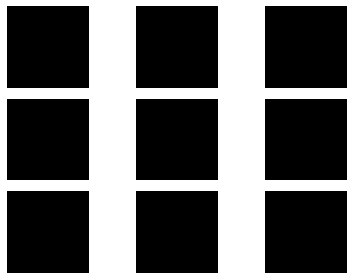

5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

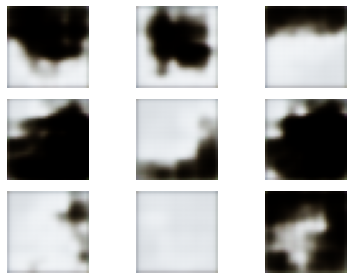

5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

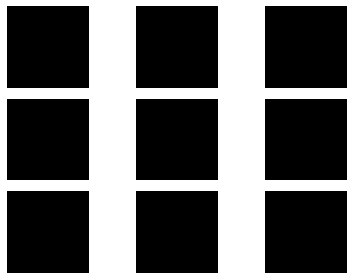

0.5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

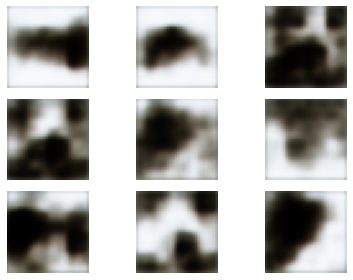

0.5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

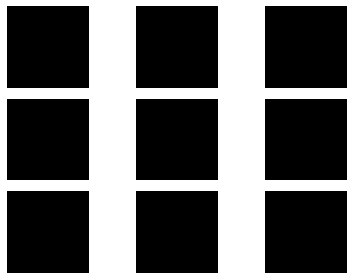

0.2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

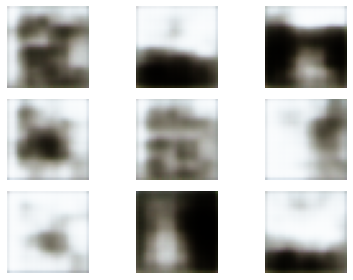

0.2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

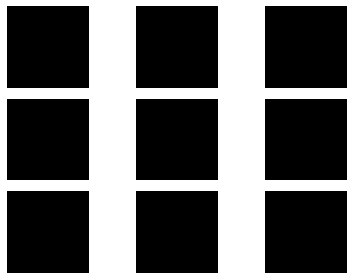

In [45]:
perform_comparison(
    [fids_2cvae_cifar10,fids_5cvae_cifar10,fids_05cvae_cifar10,fids_02cvae_cifar10],
    [losses_2cvae_cifar10,losses_5cvae_cifar10,losses_05cvae_cifar10,losses_02cvae_cifar10],
    [summaries_2cvae_cifar10,summaries_5cvae_cifar10,summaries_05cvae_cifar10,summaries_02cvae_cifar10],
    [_2CVAE_cifar10, _5CVAE_cifar10, _05CVAE_cifar10, _02CVAE_cifar10],
    cmap=None
)